# Getting started
This notebook shows how to use brambox to generate some basic detection statistics.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from IPython.display import display

import brambox as bb

# Settings
sns.set_theme(style='ticks', context='notebook', )

## Loading data
To be able to follow along with this tutorial, you can download the detection and annotation files at the following URLs:

- annotations: https://gitlab.com/EAVISE/brambox/-/blob/master/docs/notes/annotations.h5
- detections: https://gitlab.com/EAVISE/brambox/-/blob/master/docs/notes/detections.h5

<div class="alert alert-info">

**Note:**  
For this tutorial, the files were downloaded in the same directory as the notebook and saved as _detections.h5_ and _annotations.h5_.

</div>

In order to load and save data, brambox comes with 2 functions [brambox.io.load()](../api/generated/brambox.io.load.rst) and [brambox.io.save()](../api/generated/brambox.io.save.rst).  
These functions allow brambox to load and save data in various formats. For a complete list of supported formats, [click here](../api/io.rst#formats).

The annotations and detections we downloaded are pandas pickle files.  
We can load them in brambox by using the [PandasParser](../api/generated/brambox.io.parser.generic.PandasParser.rst), which is a special parser that can parse both annotations and detections from any format that is supported by pandas.

In [2]:
# Load detections
det = bb.io.load('pandas', 'detections.h5')
print('detections:')
display(det.head())

# Load annotations
anno = bb.io.load('pandas', 'annotations.h5')
print('annotations:')
display(anno.head())

detections:


image  class_label  x_top_left  y_top_left       width  \
0  VOC2007/JPEGImages/000001       person    8.430041   14.934265  347.032144   
1  VOC2007/JPEGImages/000001       person -139.202274   47.109200  407.532582   
2  VOC2007/JPEGImages/000001    tvmonitor   47.424234  -16.603681  180.063119   
3  VOC2007/JPEGImages/000001       person  -19.912014   43.759915  167.932162   
4  VOC2007/JPEGImages/000001  pottedplant  -72.148401    0.632340   39.973158   

       height  confidence  
0  469.467200    0.918144  
1  476.236930    0.001322  
2   76.554647    0.001324  
3  412.984775    0.001346  
4   36.604006    0.001346

annotations:


image class_label  x_top_left  y_top_left  width  \
0  VOC2007/JPEGImages/000001         dog   48.000000       240.0  148.0   
1  VOC2007/JPEGImages/000001      person    8.000000        12.0  345.0   
2  VOC2007/JPEGImages/000002       train  140.201923       200.0   69.0   
3  VOC2007/JPEGImages/000003        sofa  123.000000       155.0   93.0   
4  VOC2007/JPEGImages/000003       chair  239.000000       156.0   69.0   

   height  ignore  
0   132.0   False  
1   487.0   False  
2   102.0   False  
3    41.0   False  
4    50.0   False

As you can see, the data is stored as a regular pandas DataFrame.  
The only special column is the _'image'_ column, which is of a categorical type.
This means it can only contain a fixed set of possible values and thus allows us to set all the images of the dataset as a category. This, in turn, allows to keep a list of all images, regardless of whether they contain bounding boxes.

<div class="alert alert-warning">

**Warning:**  
The only drawback of using a categorical column, is that pandas does some weird things when concatenating multiple dataframes with categorical columns or when adding a new row.
This is why we provide a set of functions to do just that in the [brambox.util](../api/util.rst#dataframe-manipulation) submodule.

</div>

In [3]:
anno.image.cat.categories

Index(['VOC2007/JPEGImages/000001', 'VOC2007/JPEGImages/000002',
       'VOC2007/JPEGImages/000003', 'VOC2007/JPEGImages/000004',
       'VOC2007/JPEGImages/000006', 'VOC2007/JPEGImages/000008',
       'VOC2007/JPEGImages/000010', 'VOC2007/JPEGImages/000011',
       'VOC2007/JPEGImages/000013', 'VOC2007/JPEGImages/000014',
       ...
       'VOC2007/JPEGImages/009943', 'VOC2007/JPEGImages/009948',
       'VOC2007/JPEGImages/009951', 'VOC2007/JPEGImages/009952',
       'VOC2007/JPEGImages/009953', 'VOC2007/JPEGImages/009956',
       'VOC2007/JPEGImages/009957', 'VOC2007/JPEGImages/009960',
       'VOC2007/JPEGImages/009962', 'VOC2007/JPEGImages/009963'],
      dtype='object', length=4952)

## Exploratory analysis
As the data is stored as a DataFrame, you can use the full power of the pandas library and any other library that builds upon it to perform any kind of operations.
Here we will show some basics that can be done out-of-the-box with pandas.

In [4]:
det['area'] = det.width * det.height
display(det.head())
det = det.drop(columns=['area'])  # Remove area column for later

image  class_label  x_top_left  y_top_left       width  \
0  VOC2007/JPEGImages/000001       person    8.430041   14.934265  347.032144   
1  VOC2007/JPEGImages/000001       person -139.202274   47.109200  407.532582   
2  VOC2007/JPEGImages/000001    tvmonitor   47.424234  -16.603681  180.063119   
3  VOC2007/JPEGImages/000001       person  -19.912014   43.759915  167.932162   
4  VOC2007/JPEGImages/000001  pottedplant  -72.148401    0.632340   39.973158   

       height  confidence           area  
0  469.467200    0.918144  162920.208647  
1  476.236930    0.001322  194082.065793  
2   76.554647    0.001324   13784.668510  
3  412.984775    0.001346   69353.426048  
4   36.604006    0.001346    1463.177701

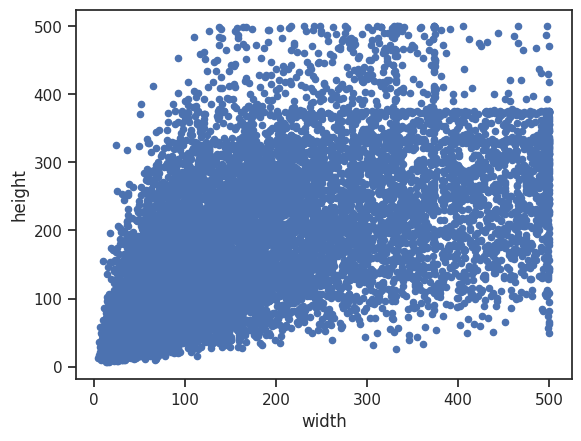

In [5]:
anno.plot('width', 'height', kind='scatter')
plt.show()

## Statistical Analysis
Brambox provides a set of functions to perform various statistical analyses of detections through its [brambox.stat](../api/stat.rst) submodule.  
As an example, we will generate a [PR-curve](https://en.wikipedia.org/wiki/Precision_and_recall) for the previously shown data and use it to choose a working point for our detector.

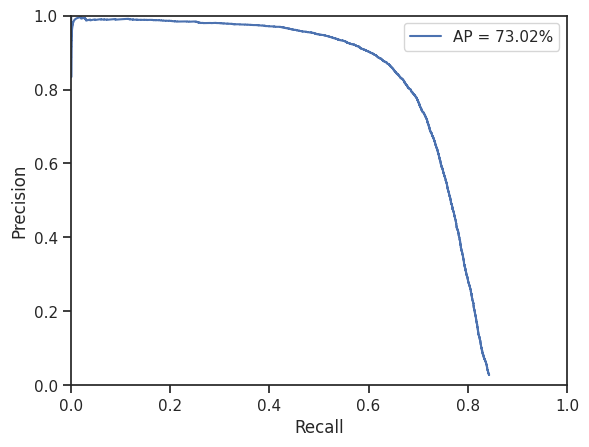

In [6]:
pr = bb.stat.pr(det, anno, 0.5)  # IoU threshold of 0.5
ap = bb.stat.ap(pr)

ax = pr.plot('recall', 'precision', drawstyle='steps', label=f'AP = {round(100*ap, 2)}%')
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
plt.show()

Now that we have a PR-curve, we can use it to find a detection threshold at which we want to use our detector.
Such a threshold is called a working point or operation point.
For example, if we want to have the highest precision possible, whilst having a recall of at least 60%, we can find that working point by running the following code:

In [7]:
row = bb.stat.threshold(pr, 'recall', 0.6)
display(row)
print(f'Working Point: {round(row.confidence*100, 2)}%')

precision     0.902387
recall        0.600066
confidence    0.571040
Name: 7994, dtype: float64

Working Point: 57.1%


However, if you don't have any such requirements _(ie. recall >= 60%)_ and just want to find a working point with a certain optimal balance between precision and recall, you can use the [F-score](https://en.wikipedia.org/wiki/F1_score) metric.
Here we will show an example of finding a working point with an optimal F1-score and then we will plot that working point on our PR-curve.

F1 Working Point:


f1            0.739900
recall        0.668966
confidence    0.431020
Name: 9718, dtype: float64

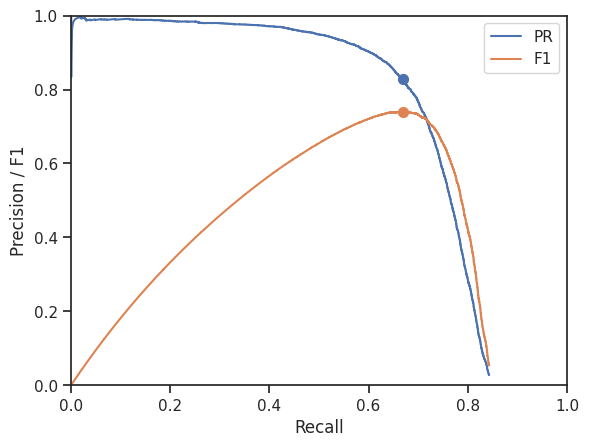

In [8]:
# Find detection threshold with maximal F1
f1 = bb.stat.fscore(pr)
threshold = bb.stat.peak(f1)
print('F1 Working Point:')
display(threshold)

# Find point on PR-curve that matches the computed detection threshold
pr_point = bb.stat.point(pr, threshold.confidence)

# Plot
ax = pr.plot('recall', 'precision', label='PR')
plt.scatter(pr_point.recall, pr_point.precision, s=50)
f1.plot('recall', 'f1', label='F1', ax=ax)
plt.scatter(threshold.recall, threshold.f1, s=50)

ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_xlabel('Recall')
ax.set_ylabel('Precision / F1')
plt.show()

## Visualisation
Now that we computed a working point, we can filter our detections and visualize them on the images.
In this last part of our tutorial, we will visualize the _True Positive_ detections in green, the _False Positive_ detections in red and the missing _False Negative_ objects in blue.

<div class="alert alert-info">

**Note:**  
This dataset is from the Pascal VOC challenge. To be able to run this notebook, you need to [download](http://host.robots.ox.ac.uk/pascal/VOC/voc2007/index.html#testdata) the images and place them in an _images_ directory (When extracting the tar archive, the `VOCdevkit` folder should become your `images` folder).  
__We do not own any of the images shown here!__

</div>

First, we need to compute these _True Positive_, _False Positive_ and _False Negative_ boxes.

<div class="alert alert-info">

**Note:**  
Instead of using both [brambox.stat.match_det()](../api/generated/brambox.stat.match_det.rst) and [brambox.stat.match_anno()](../api/generated/brambox.stat.match_anno.rst) separately, you can use the [brambox.stat.match_box()](../api/generated/brambox.stat.match_box.rst) function, which combines both and is faster to execute.

</div>

In [9]:
# Filter detections based on threshold (computed in previous step from F1-curve)
filtered_det = det[det.confidence >= threshold.confidence].copy()

# Compute TP,FP
tpfp_det = bb.stat.match_det(filtered_det, anno, 0.5)
# match_det() returns detections with a 'tp' and 'fp' column.
print('TP FP:')
display(tpfp_det.head())

# Compute FN
fn_anno = bb.stat.match_anno(filtered_det, anno, 0.5)
# match_anno() returns annotations with a 'detection' column that has the index of the matched detection
# We use this to filter unmatched annotations (NaN as index)
fn_anno = fn_anno[fn_anno.detection.isnull()]
print('FN:')
display(fn_anno.head())

TP FP:


image  class_label  x_top_left  y_top_left  \
136413  VOC2007/JPEGImages/003668  diningtable   49.729054  169.802556   
215831  VOC2007/JPEGImages/005758  diningtable  -17.300312   88.933019   
144753  VOC2007/JPEGImages/003894  diningtable   13.020112  117.372825   
55622   VOC2007/JPEGImages/001489  diningtable   14.264602   88.528468   
169684  VOC2007/JPEGImages/004525  diningtable   68.726301  -15.469349   

             width      height  confidence    tp     fp  annotation  
136413  325.228068  172.955733    0.998280  True  False      5537.0  
215831  544.822583  285.960252    0.996462  True  False      8631.0  
144753  474.034529  243.884527    0.994926  True  False      5861.0  
55622   456.298901  244.929607    0.994851  True  False      2263.0  
169684  424.157436  353.741059    0.993922  True  False      6871.0

FN:


image class_label  x_top_left  y_top_left  width  \
3   VOC2007/JPEGImages/000003        sofa       123.0       155.0   93.0   
4   VOC2007/JPEGImages/000003       chair       239.0       156.0   69.0   
11  VOC2007/JPEGImages/000004         car        84.0       323.0   38.0   
13  VOC2007/JPEGImages/000006       chair       137.0       198.0   20.0   
14  VOC2007/JPEGImages/000006       chair       137.0       192.0   15.0   

    height  ignore  detection  criteria  
3     41.0   False        NaN       0.0  
4     50.0   False        NaN       0.0  
11    28.0   False        NaN       0.0  
13    15.0    True        NaN       0.0  
14     8.0    True        NaN       0.0

Now that we computed all the correct bounding boxes, we need to merge these two dataframes so that our [BoxDrawer](../api/generated/brambox.util.BoxDrawer.rst) class can correctly draw all the necessary boxes on the images.
We will also need to add some columns to tell the [BoxDrawer](../api/generated/brambox.util.BoxDrawer.rst) how to draw these boxes (color, width, etc).

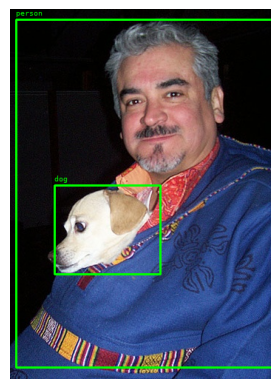

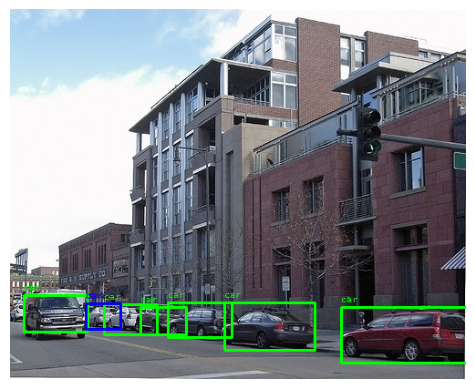

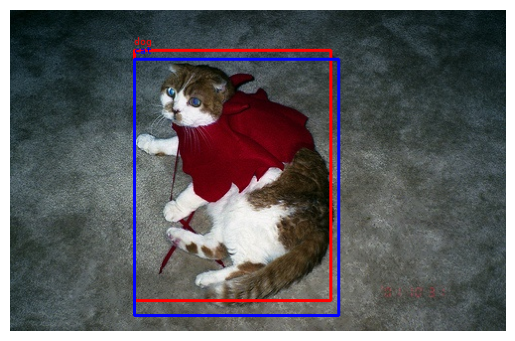

In [10]:
# Add correct color
tpfp_det['color'] = [(0, 255, 0) if tp else (255, 0, 0) for tp in tpfp_det.tp]  # TP boxes green, FP boxes red
fn_anno['color'] = [(0, 0, 255)] * fn_anno.shape[0]                             # FN boxes blue

# Only keep necessary columns (to be able to combine dataframes)
boxes1 = tpfp_det[['image', 'class_label', 'x_top_left', 'y_top_left', 'width', 'height', 'color']]
boxes2 = fn_anno[['image', 'class_label', 'x_top_left', 'y_top_left', 'width', 'height', 'color']]

# Concatenate dataframes
boxes = bb.util.concat([boxes1, boxes2], sort=False, ignore_index=True)

# Visualize
drawer = bb.util.BoxDrawer(
    images=lambda img: f'images/{img}.jpg',  # Function to retrieve image path from image column name
    boxes=boxes,
    label=boxes.class_label,                 # Write class_label above boxes
)

# drawer is an iterable that will loop over all images and draw them (Here it returns PIL images)
plt.axis('off')
plt.imshow(np.asarray(drawer[0]))
plt.show()

plt.axis('off')
plt.imshow(np.asarray(drawer[3]))
plt.show()

plt.axis('off')
plt.imshow(np.asarray(drawer[7]))
plt.show()

These visualizations allow us to better understand where the detector fails.  
For instance, in the last image we can see a cat _(blue FN annotation box)_.
Our detector however detected this as being a dog _(red FP detection box)_, which might be seen as an understandable mistake.

<div class="alert alert-info">

**Note:**  
If you want an easier tool to visualize brambox datasets inside of jupyter notebooks, feel free to take a look at [IBB](https://github.com/0phoff/ibb), which adds useful IPython widgets to your notebook to be able to browse through the images of your dataset.

</div>